# Plot Run Data
This notebook plots the performance of a run to assess the optimization performance and system utilization.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import os

Load the run information 

In [2]:
run_info = pd.read_csv('run_data.csv')

Pick one

In [3]:
run_info = run_info.sort_values('start_time', ascending=False).iloc[0]
print(run_info)

path            runs/reallocate-N100-P8-120421-092359
start_time                        2021-04-12 09:23:59
num_guesses                                       100
num_parallel                                        8
retrain_wait                                       20
dim                                                 4
runtime                                             2
runtime_var                                         1
opt_delay                                        20.0
file                                  reallocation.py
worker_count                                        8
n_evals                                           100
Name: 0, dtype: object


## Load in Result File
This file is the list of the quantum chemistry results

In [4]:
result_data = pd.read_json(os.path.join(run_info['path'], 'results.json'), lines=True)

Plot the time since first result

In [5]:
result_data['walltime'] = result_data['time_result_received'] - result_data['time_created'].min()

Plot the rate at which we aquired new results

## Evaluate Runtimes
Estimate the runtimes of the QC code

In [6]:
result_data['time_running'].describe()

count    100.000000
mean       8.813667
std        6.987725
min        1.056527
25%        3.545347
50%        6.572098
75%       12.115558
max       36.930310
Name: time_running, dtype: float64

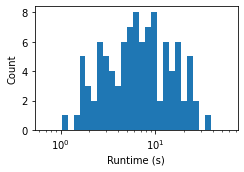

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

min_log = np.log10(result_data.time_running).min()
max_log = np.log10(result_data.time_running).max()
ax.hist(result_data['time_running'], bins=np.logspace(min_log - 0.2, max_log + 0.2, 32))
ax.set_xscale('log')

ax.set_xlabel('Runtime (s)')
ax.set_ylabel('Count')
fig.tight_layout()

## Evaluate Performance
See if we are getting better over time

In [8]:
result_data['time_running'].describe()

count    100.000000
mean       8.813667
std        6.987725
min        1.056527
25%        3.545347
50%        6.572098
75%       12.115558
max       36.930310
Name: time_running, dtype: float64

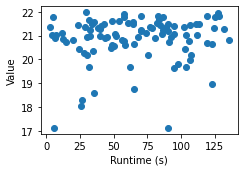

In [28]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.scatter(result_data['walltime'], result_data['value'])

ax.set_xlabel('Runtime (s)')
ax.set_ylabel('Value')
fig.tight_layout()

## Plot the Number of Simulations Being Run at a Time
We can look at the runtime log to get when simualtions tasks start computing and when they finish

In [10]:
with open(os.path.join(run_info['path'], 'runtime.log')) as fp:
    log_data = pd.DataFrame(f.rstrip() for f in fp)
log_data.rename(columns={0: 'msg'}, inplace=True)
log_data['msg_num'] = log_data['msg'].str.match(r'^[\d]').cumsum()
log_data = log_data.groupby('msg_num').agg({'msg': lambda x: '\n'.join(x)})

In [11]:
log_data['time'], log_data['module'], log_data['level'], log_data['content'] = zip(*log_data['msg'].str.split(" - ", 3))

Compute the time since first message

In [12]:
log_data['time'] = pd.to_datetime(log_data['time'], utc=False)

In [13]:
log_data['walltime'] = (log_data['time'] - log_data['time'].iloc[0]).apply(lambda x: x.total_seconds())

In [14]:
start_time = log_data['time'].iloc[0].timestamp()

Find the events related to calculations starting and finishing

In [15]:
start_time = result_data['time_created'].min()

In [16]:
events = [{'time': 0, 'active_delta': 0}]
events.extend({'time': t - start_time, 'active_delta': -1} for t in 
          (result_data['time_compute_started'] + result_data['time_running']))
events.extend([{'time': t - start_time, 'active_delta': 1} for t in result_data['time_compute_started']])
events = pd.DataFrame(events)

Make the results easier to plot

In [17]:
events.sort_values('time', ascending=True, inplace=True)

In [18]:
events['num_active'] = events['active_delta'].cumsum()

Compute worker utilization

In [19]:
events['queue_length'] = events['num_active']

In [20]:
events['utilization'] = np.clip(events['queue_length'] / run_info['worker_count'], 0, 1)

In [21]:
utilization_int = (np.diff(events['time'].values) * events['utilization'].values[:-1]).cumsum()

Compute the cumulative utilization

In [22]:
def cumulative_utilization(time: float) -> float:
    """Compute average utilization over time"""
    # Integrating knowing that we have a piecewise functions
    # Integrate over all of the pieces before the current piece
    past_events = events[events.time <= time]
    if len(past_events) <= 1:
        return 0.0
    past_util = (np.diff(past_events['time'].values) * past_events['utilization'].values[:-1]).sum()
    
    # Integrate the current piece
    current_event = past_events.iloc[-1]
    current_util = (time - current_event.time) * current_event.utilization
    return (past_util + current_util) / time

In [23]:
%%time
times = np.linspace(0, events.time.max(), 1024)
utilization = np.array([cumulative_utilization(x) for x in times])

CPU times: user 663 ms, sys: 3.63 ms, total: 666 ms
Wall time: 663 ms


Plot the queue length and utilization

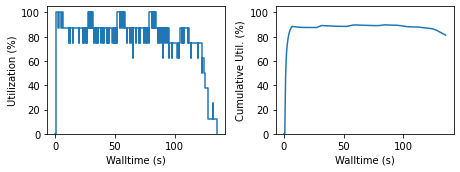

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.5))

# Plot the queue length
ax = axs[0]
ax.step(events['time'], events['utilization'] * 100, where='post')
ax.set_xlabel('Walltime (s)')
ax.set_ylabel('Utilization (%)')
ax.set_ylim(0, 105)

ax = axs[1]
ax.plot(times, utilization * 100)
ax.set_xlabel('Walltime (s)')
ax.set_ylabel('Cumulative Util. (%)')
ax.set_ylim(0, 105)

fig.tight_layout()
fig.savefig('utilization.png', dpi=320)

## Plot Assignment to Different "Nodes"
See how work is distributed

In [25]:
retrain_data = pd.read_json(os.path.join(run_info["path"], "retrain.json"), lines=True)

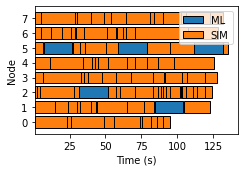

In [26]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

for label, data in zip(['ML', 'SIM'], [retrain_data, result_data]):
    data["worker"] = data['task_info'].apply(lambda x: int(x["PARSL_WORKER_RANK"]))
    ax.barh(y=data["worker"], width=data["time_running"], left=data["time_compute_started"] - start_time, label=label, edgecolor='k')
    
ax.set_yticks(np.arange(data["worker"].max() + 1))
ax.set_ylabel('Node')

ax.set_xlabel('Time (s)')
ax.legend()
fig.tight_layout()
fig.savefig('figures/allocation.png', dpi=320)